In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    mean_squared_error,
    r2_score,
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

from skbio.diversity import alpha_diversity, beta_diversity
from skbio.stats.ordination import pcoa
from skbio.diversity.alpha import shannon
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, pearsonr
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

In [85]:
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()

In [86]:
data1 = pd.read_csv('/Users/vbuttros/Library/CloudStorage/OneDrive-Personal/University/Microbiology - DSc/Colaborations/Buttros, VH/R_solanii_ANN/Treated_data/dataset1_script_files/merged_data.csv')
data2 = pd.read_csv('/Users/vbuttros/Library/CloudStorage/OneDrive-Personal/University/Microbiology - DSc/Colaborations/Buttros, VH/R_solanii_ANN/Treated_data/dataset2_script_files/merged_data.csv')

In [87]:
def remove_duplicate_samples(data, predictor_columns):
    """
    Removes one occurrence of rows with duplicate values across all predictor columns.

    Parameters:
    - data (pd.DataFrame): The input DataFrame containing predictors and other columns.
    - predictor_columns (list): A list of predictor column names to check for duplicates.

    Returns:
    - pd.DataFrame: A DataFrame with duplicates removed but one instance retained.
    """
    # Remove duplicates, keeping the first occurrence
    filtered_data = data[~data.duplicated(subset=predictor_columns, keep='first')]
    return filtered_data

def shuffle_samples(data, random_state=None):
    """
    Shuffles the rows of a DataFrame randomly.

    Parameters:
    - data (pd.DataFrame): The input DataFrame to shuffle.
    - random_state (int, optional): A seed for reproducibility of the shuffle.

    Returns:
    - pd.DataFrame: A DataFrame with shuffled rows.
    """
    shuffled_data = shuffle(data, random_state=random_state).reset_index(drop=True)
    return shuffled_data



In [88]:
# Identify classifiers, predictors, and target columns
classifiers1 = [col for col in data1.columns if col.startswith('K_')]
predictors1 = [col for col in data1.columns if col.startswith('P_')]
target1 = [col for col in data1.columns if col.startswith('Y_')]

classifiers2 = [col for col in data2.columns if col.startswith('K_')]
predictors2 = [col for col in data2.columns if col.startswith('P_')]
target2 = [col for col in data2.columns if col.startswith('Y_')]

In [89]:
data1 = remove_duplicate_samples(data1, predictors1)
data2 = remove_duplicate_samples(data2, predictors2)

In [90]:
data1[predictors1] = scaler1.fit_transform(data1[predictors1])
data2[predictors2] = scaler1.fit_transform(data2[predictors2])

In [91]:
# Identify common predictors and target columns
common_predictors = list(set(predictors1).intersection(set(predictors2)))
common_target = list(set(target1).intersection(set(target2)))

# Align datasets by column fidelity (ensure missing columns are added as NaN)
all_columns = list(set(data1.columns).union(set(data2.columns)))
data1 = data1.reindex(columns=all_columns)
data2 = data2.reindex(columns=all_columns)

# Merge datasets while aligning columns and preserving column fidelity
merged_data = pd.concat([data1, data2], axis=0, ignore_index=True)

In [92]:
merged_data = shuffle_samples(merged_data, random_state=42)

In [93]:
classifiers = [col for col in merged_data.columns if col.startswith('K_')]
predictors = [col for col in merged_data.columns if col.startswith('P_')]
target = [col for col in merged_data.columns if col.startswith('Y_')]

In [94]:
# Impute missing values for predictors
imputer = KNNImputer(n_neighbors=5)
merged_data[predictors] = imputer.fit_transform(merged_data[predictors])

In [95]:
pmax = max(merged_data['Y_rs.dis'])
pmin = min(merged_data['Y_rs.dis'])
print("Max:", pmax, "Min:", pmin)
severity_threshold = 40
threshold_value = (severity_threshold / 100) * (pmax - pmin) + pmin
print("Equivalent value for severity threshold:", threshold_value)

Max: 100.0 Min: 0.0
Equivalent value for severity threshold: 40.0


In [96]:
# Create a binary classification target
merged_data['Class'] = np.where(merged_data[target].values > 20, 'Conducive', 'Suppressive')
merged_data['Class'] = merged_data['Class'].map({'Suppressive': 0, 'Conducive': 1})

In [97]:
# Split the data into training and testing sets
X = merged_data[predictors]
y = merged_data['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [98]:
# Train the ANN model
ann = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, verbose=True)
ann.fit(X_train, y_train)

Iteration 1, loss = 0.80569866
Iteration 2, loss = 0.67879367
Iteration 3, loss = 0.59063755
Iteration 4, loss = 0.53568406
Iteration 5, loss = 0.49889436
Iteration 6, loss = 0.47680462
Iteration 7, loss = 0.46314312
Iteration 8, loss = 0.45296253
Iteration 9, loss = 0.44367711
Iteration 10, loss = 0.43382971
Iteration 11, loss = 0.42308516
Iteration 12, loss = 0.41063300
Iteration 13, loss = 0.39887307
Iteration 14, loss = 0.38574184
Iteration 15, loss = 0.37486568
Iteration 16, loss = 0.36215295
Iteration 17, loss = 0.35107246
Iteration 18, loss = 0.34098481
Iteration 19, loss = 0.32980147
Iteration 20, loss = 0.31996145
Iteration 21, loss = 0.30999726
Iteration 22, loss = 0.30105173
Iteration 23, loss = 0.29149669
Iteration 24, loss = 0.28317961
Iteration 25, loss = 0.27436546
Iteration 26, loss = 0.26618000
Iteration 27, loss = 0.25722105
Iteration 28, loss = 0.24905511
Iteration 29, loss = 0.24138251
Iteration 30, loss = 0.23372775
Iteration 31, loss = 0.22615274
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42,
              verbose=True)

In [99]:
# Predict on the test set
y_pred_ann = ann.predict(X_test)


Confusion Matrix:
[[105   3]
 [ 10  21]]


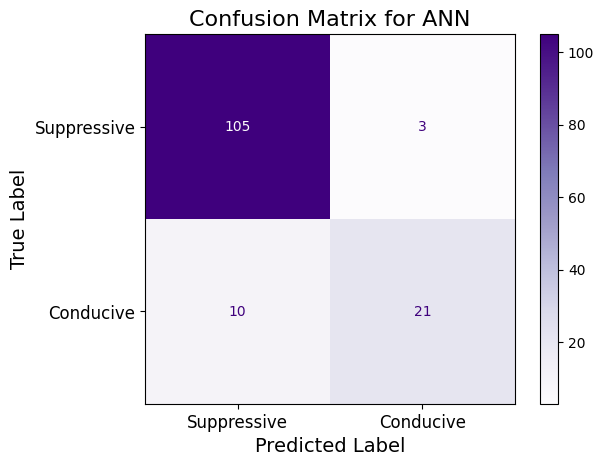

In [100]:
# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred_ann, labels=ann.classes_)
print("\nConfusion Matrix:")
print(cm)

# Customize font sizes
font_title = 16  # Title font size
font_labels = 14  # Axis label font size
font_ticks = 12  # Tick label font size

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Suppressive', 'Conducive'])
disp.plot(cmap=plt.cm.Purples)

# Set title and customize text sizes
plt.title('Confusion Matrix for ANN', fontsize=font_title)
plt.xlabel('Predicted Label', fontsize=font_labels)
plt.ylabel('True Label', fontsize=font_labels)
plt.xticks(fontsize=font_ticks)
plt.yticks(fontsize=font_ticks)

plt.show()

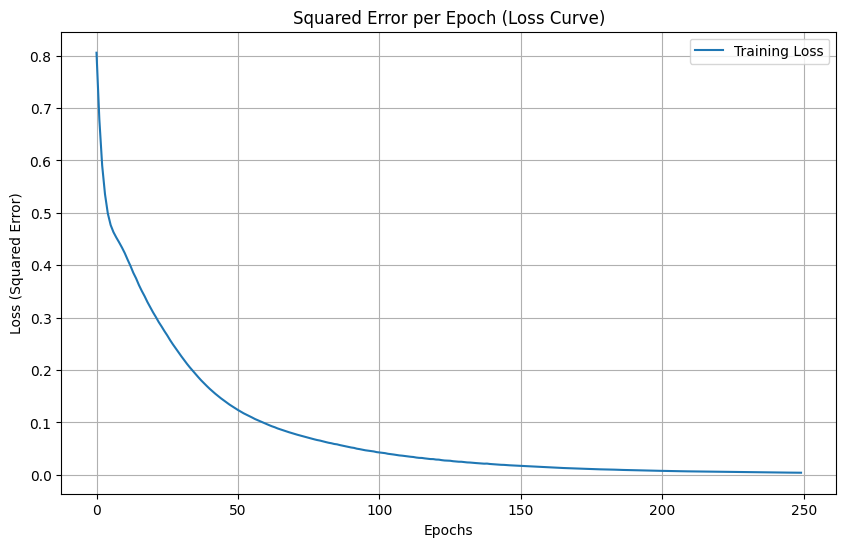

In [101]:
# Plot the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(ann.loss_curve_, label='Training Loss')
plt.title('Squared Error per Epoch (Loss Curve)')
plt.xlabel('Epochs')
plt.ylabel('Loss (Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

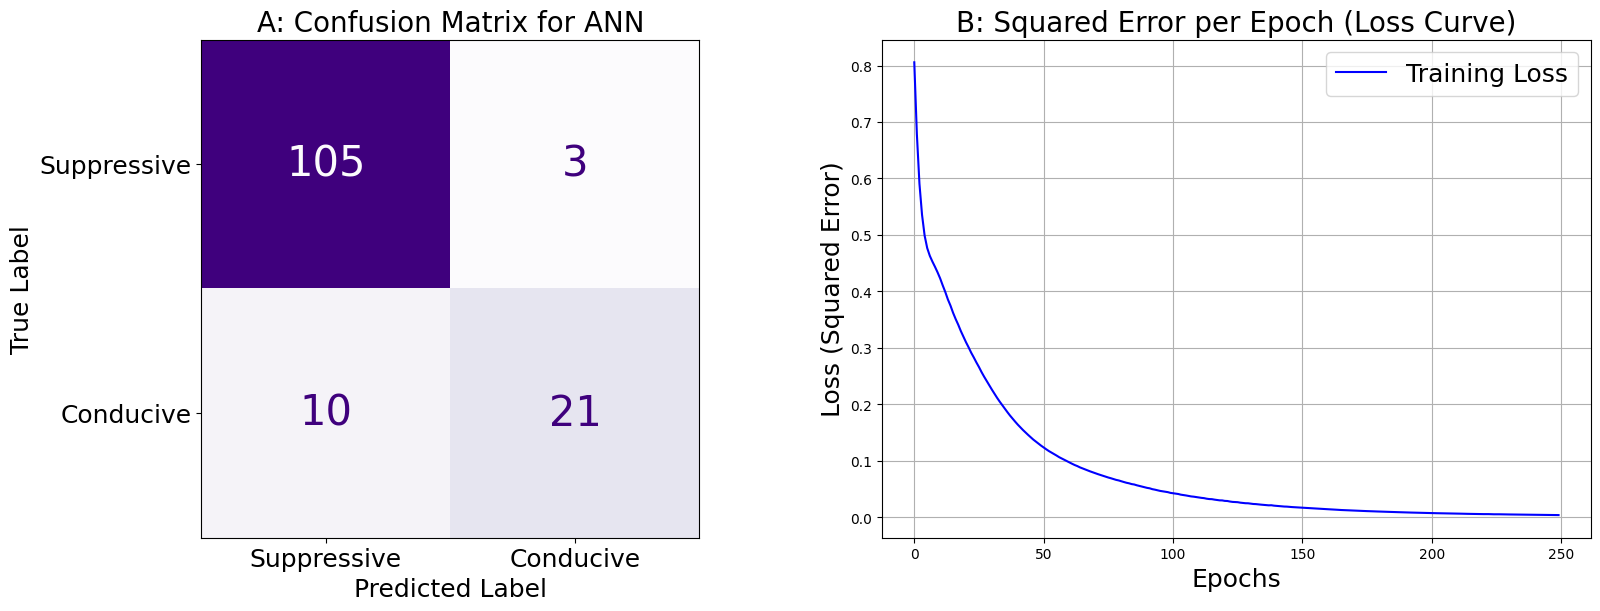

In [102]:
# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred_ann, labels=ann.classes_)

# Customize font sizes
font_title = 20  # Title font size
font_labels = 18  # Axis label font size
font_ticks = 18  # Tick label font size
font_cm_numbers = 30  # Font size for the numbers inside the confusion matrix

# Create the figure and axes for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot A: Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Suppressive', 'Conducive'])
disp.plot(cmap=plt.cm.Purples, ax=axes[0], colorbar=False)
axes[0].set_title('A: Confusion Matrix for ANN', fontsize=font_title)
axes[0].set_xlabel('Predicted Label', fontsize=font_labels)
axes[0].set_ylabel('True Label', fontsize=font_labels)
axes[0].tick_params(axis='x', labelsize=font_ticks)
axes[0].tick_params(axis='y', labelsize=font_ticks)

# Customize the text inside the confusion matrix
for text in disp.text_.ravel():
    text.set_fontsize(font_cm_numbers)

# Plot B: Training Loss Curve
axes[1].plot(ann.loss_curve_, label='Training Loss', color='blue')
axes[1].set_title('B: Squared Error per Epoch (Loss Curve)', fontsize=font_title)
axes[1].set_xlabel('Epochs', fontsize=font_labels)
axes[1].set_ylabel('Loss (Squared Error)', fontsize=font_labels)
axes[1].legend(fontsize=font_labels)
axes[1].grid(True)

# Show the combined plot
plt.show()

In [103]:
# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ann))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       108
           1       0.88      0.68      0.76        31

    accuracy                           0.91       139
   macro avg       0.89      0.82      0.85       139
weighted avg       0.90      0.91      0.90       139



In [104]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Get predicted probabilities for the positive class
y_prob = ann.predict_proba(X_test)[:, 1]  # Probabilities for 'Conducive'

# Calculate ROC-AUC
roc_auc_ann = roc_auc_score(y_test, y_prob)

# Calculate accuracy
accuracy_ann = ann.score(X_test, y_test)

print(f"ROC-AUC for ANN: {roc_auc_ann:.4f}")
print(f"Accuracy for ANN: {accuracy_ann:.4f}")
# Cross-validation for classification
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_accuracies = []
cv_roc_auc = []

for train_idx, test_idx in cv.split(X, y):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    ann_cv = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=10000, random_state=42, verbose=False)
    ann_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = ann_cv.predict(X_test_cv)
    y_prob_cv = ann_cv.predict_proba(X_test_cv)[:, 1]
    
    acc = ann_cv.score(X_test_cv, y_test_cv)
    roc_auc = roc_auc_score(y_test_cv, y_prob_cv)
    
    cv_accuracies.append(acc)
    cv_roc_auc.append(roc_auc)

print("\nCross-Validation Results for ANN Classifier:")
print(f"Mean Accuracy: {np.mean(cv_accuracies):.4f}, Std: {np.std(cv_accuracies):.4f}")
print(f"Mean ROC-AUC: {np.mean(cv_roc_auc):.4f}, Std: {np.std(cv_roc_auc):.4f}")

ROC-AUC for ANN: 0.9149
Accuracy for ANN: 0.9065

Cross-Validation Results for ANN Classifier:
Mean Accuracy: 0.9458, Std: 0.0118
Mean ROC-AUC: 0.9693, Std: 0.0398


In [105]:
# Scale predictors for regression
scaler = StandardScaler()
X = merged_data[predictors]
X = scaler.fit_transform(X)

In [106]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Regression Target
y_reg = merged_data['Y_rs.dis']

# Split data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=354
)

# Train the ANN for Regression
ann_reg = MLPRegressor(hidden_layer_sizes=(100, 50), alpha=0.01, max_iter=10000, random_state=42, verbose=True)
ann_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = ann_reg.predict(X_test_reg)

# Metrics for ANN Regression
ann_mse = mean_squared_error(y_test_reg, y_pred_reg)
ann_r2 = r2_score(y_test_reg, y_pred_reg)

print("\nANN Regression Results (Hold-Out Validation):")
print(f"Mean Squared Error (MSE): {ann_mse:.4f}")
print(f"R-squared (R²): {ann_r2:.4f}")

# Cross-validation for ANN Regression
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the cross-validation results
ann_cv_mse = []
ann_cv_r2 = []

for train_idx, test_idx in kf.split(X):
    if isinstance(X, pd.DataFrame):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    else:  # Handle NumPy arrays correctly
        X_train, X_test = X[train_idx], X[test_idx]

    if isinstance(y_reg, pd.Series):
        y_train, y_test = y_reg.iloc[train_idx], y_reg.iloc[test_idx]
    else:
        y_train, y_test = y_reg[train_idx], y_reg[test_idx]

    # Define and train the ANN model
    ann_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=10000, random_state=42, verbose=False)
    ann_model.fit(X_train, y_train)
    y_pred = ann_model.predict(X_test)

    # Calculate performance metrics for this fold
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to lists
    ann_cv_mse.append(mse)
    ann_cv_r2.append(r2)

# Output cross-validation results for regression
print("\nCross-Validation Results for ANN Regression:")
print(f"Mean MSE: {np.mean(ann_cv_mse):.4f}, Std: {np.std(ann_cv_mse):.4f}")
print(f"Mean R²: {np.mean(ann_cv_r2):.4f}, Std: {np.std(ann_cv_r2):.4f}")

Iteration 1, loss = 781.74366679
Iteration 2, loss = 772.34296782
Iteration 3, loss = 762.24695638
Iteration 4, loss = 752.90013659
Iteration 5, loss = 742.62157271
Iteration 6, loss = 732.40221086
Iteration 7, loss = 722.22125897
Iteration 8, loss = 711.51060446
Iteration 9, loss = 699.86854640
Iteration 10, loss = 688.76753453
Iteration 11, loss = 676.06680501
Iteration 12, loss = 663.92857956
Iteration 13, loss = 650.06899617
Iteration 14, loss = 636.56460890
Iteration 15, loss = 622.94184980
Iteration 16, loss = 607.83923809
Iteration 17, loss = 593.41421297
Iteration 18, loss = 578.29427090
Iteration 19, loss = 564.19967781
Iteration 20, loss = 549.67824671
Iteration 21, loss = 534.68195687
Iteration 22, loss = 522.08704791
Iteration 23, loss = 508.51255935
Iteration 24, loss = 497.13043971
Iteration 25, loss = 485.14960952
Iteration 26, loss = 474.87841296
Iteration 27, loss = 466.37894037
Iteration 28, loss = 458.16322345
Iteration 29, loss = 450.20932117
Iteration 30, loss = 44

In [107]:
# Predict on the test set
y_pred_reg_ann = ann_reg.predict(X_test_reg)


Mean Squared Error (MSE): 164.0758
R-squared (R2): 0.7287


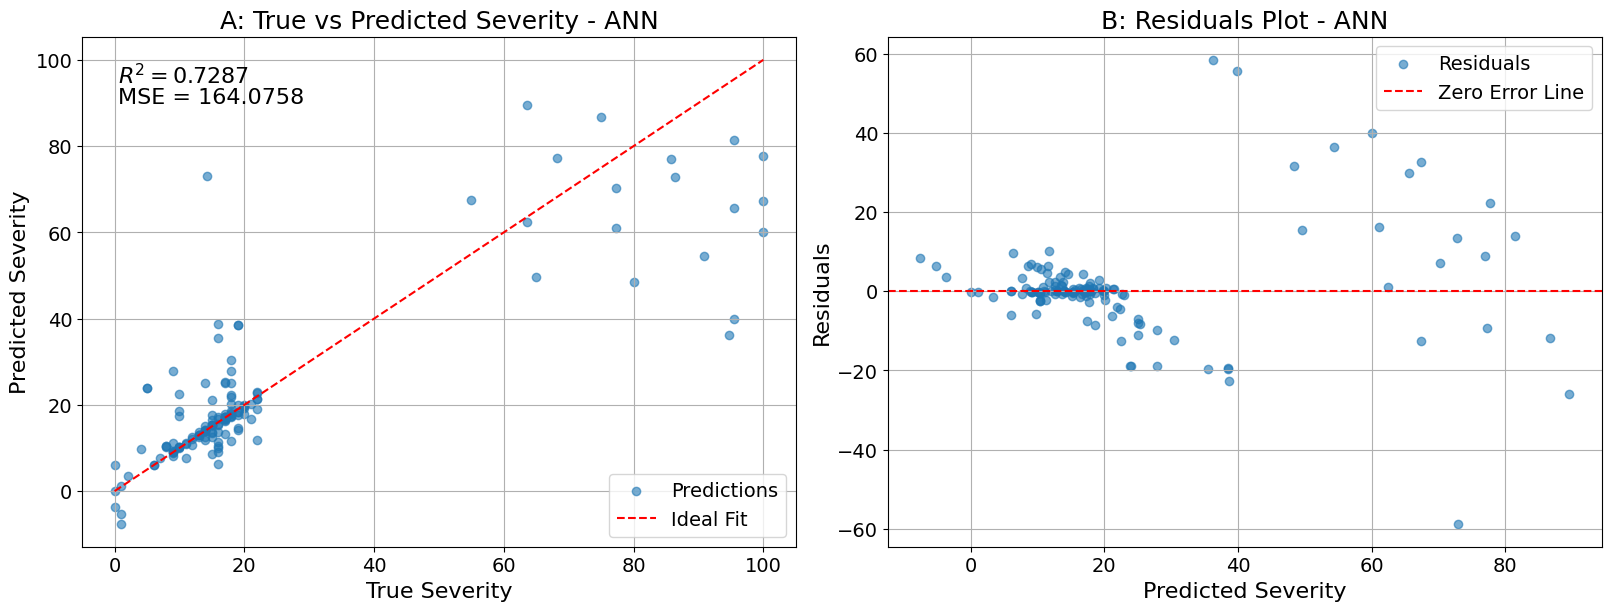

In [108]:
# Regression Metrics
ann_mse = mean_squared_error(y_test_reg, y_pred_reg_ann)
ann_r2 = r2_score(y_test_reg, y_pred_reg_ann)
print(f"\nMean Squared Error (MSE): {ann_mse:.4f}")
print(f"R-squared (R2): {ann_r2:.4f}")
# Font sizes
font_title = 18  # Title font size
font_labels = 16  # Axis label font size
font_ticks = 14  # Tick label font size
font_legend = 14  # Legend font size

# Residuals
residuals = y_test_reg - y_pred_reg_ann

# Plot Predicted vs True values and Residuals side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot A: True vs Predicted
axes[0].scatter(y_test_reg, y_pred_reg_ann, alpha=0.6, label='Predictions')
axes[0].plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], 'r--', label='Ideal Fit')
axes[0].set_xlabel('True Severity', fontsize=font_labels)
axes[0].set_ylabel('Predicted Severity', fontsize=font_labels)
axes[0].set_title('A: True vs Predicted Severity - ANN', fontsize=font_title)
axes[0].legend(fontsize=font_legend)
axes[0].grid(True)
axes[0].tick_params(axis='x', labelsize=font_ticks)
axes[0].tick_params(axis='y', labelsize=font_ticks)

# Add MSE and R² annotations
axes[0].text(
    0.05,
    0.95,
    f"$R^2 = {ann_r2:.4f}$",
    fontsize=font_labels,
    transform=axes[0].transAxes,
    verticalalignment='top'
)
axes[0].text(
    0.05,
    0.90,
    f"MSE = {ann_mse:.4f}",
    fontsize=font_labels,
    transform=axes[0].transAxes,
    verticalalignment='top'
)

# Plot B: Residuals
axes[1].scatter(y_pred_reg_ann, residuals, alpha=0.6, label='Residuals')
axes[1].axhline(0, color='r', linestyle='--', label='Zero Error Line')
axes[1].set_xlabel('Predicted Severity', fontsize=font_labels)
axes[1].set_ylabel('Residuals', fontsize=font_labels)
axes[1].set_title('B: Residuals Plot - ANN', fontsize=font_title)
axes[1].legend(fontsize=font_legend)
axes[1].grid(True)
axes[1].tick_params(axis='x', labelsize=font_ticks)
axes[1].tick_params(axis='y', labelsize=font_ticks)

# Show the combined plot
plt.show()

In [109]:
# Split the data into training and testing sets
X = merged_data[predictors]
y = merged_data['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=855, stratify=y
)
# Random Forest for Classification
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]
# Metrics for Random Forest Classification
rf_cm = confusion_matrix(y_test, y_pred_rf)
rf_acc = rf_clf.score(X_test, y_test)
rf_roc_auc = roc_auc_score(y_test, y_prob_rf)
print("\nRandom Forest Classification:")
print(f"Accuracy: {rf_acc:.4f}")
print(f"ROC-AUC: {rf_roc_auc:.4f}")
print("Confusion Matrix:")
print(rf_cm)
# Cross-validation for Random Forest Classification
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_accuracies = cross_val_score(rf_clf, X, y, cv=cv, scoring='accuracy')
rf_cv_roc_auc = cross_val_score(rf_clf, X, y, cv=cv, scoring='roc_auc')
print("\nRandom Forest Cross-Validation Results:")
print(f"Mean Accuracy: {np.mean(rf_cv_accuracies):.4f}, Std: {np.std(rf_cv_accuracies):.4f}")
print(f"Mean ROC-AUC: {np.mean(rf_cv_roc_auc):.4f}, Std: {np.std(rf_cv_roc_auc):.4f}")


Random Forest Classification:
Accuracy: 0.9928
ROC-AUC: 1.0000
Confusion Matrix:
[[108   0]
 [  1  30]]

Random Forest Cross-Validation Results:
Mean Accuracy: 0.9892, Std: 0.0136
Mean ROC-AUC: 0.9817, Std: 0.0252


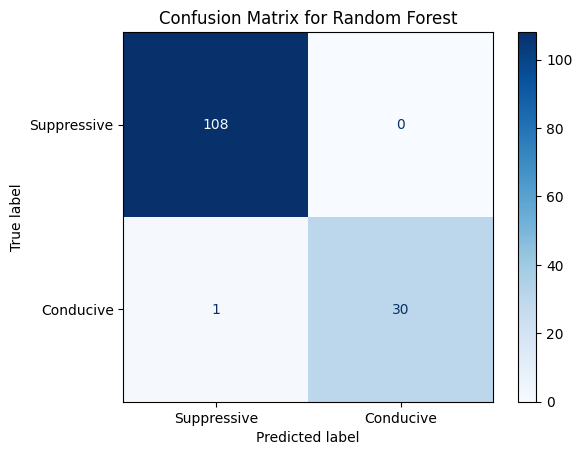

In [110]:
# Plot confusion matrix for Random Forest
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=['Suppressive', 'Conducive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [111]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Regression Target
y_reg = merged_data['Y_rs.dis']

# Split data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=42
)

# Random Forest for Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)
y_pred_rf_reg = rf_reg.predict(X_test_reg)

# Metrics for Random Forest Regression
rf_mse = mean_squared_error(y_test_reg, y_pred_rf_reg)
rf_r2 = r2_score(y_test_reg, y_pred_rf_reg)

print("\nRandom Forest Regression:")
print(f"Mean Squared Error (MSE): {rf_mse:.4f}")
print(f"R-squared (R2): {rf_r2:.4f}")

# Cross-validation for Random Forest Regression
kf_r = KFold(n_splits=5, shuffle=True, random_state=42)

rf_cv_mse_r = []
rf_cv_r2_r = []

for train_idx, test_idx in kf_r.split(X):
    # Ensure indexing works correctly for DataFrame or NumPy array
    X_train_rf_cv_r, X_test_rf_cv_r = X.iloc[train_idx], X.iloc[test_idx] if isinstance(X, pd.DataFrame) else (X[train_idx], X[test_idx])
    y_train_rf_cv_r, y_test_rf_cv_r = y_reg.iloc[train_idx], y_reg.iloc[test_idx]
    
    rf_reg_cv_r = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_reg_cv_r.fit(X_train_rf_cv_r, y_train_rf_cv_r)
    y_pred_rf_cv_r = rf_reg_cv_r.predict(X_test_rf_cv_r)
    
    # Calculate metrics
    mse_r = mean_squared_error(y_test_rf_cv_r, y_pred_rf_cv_r)
    r2_r = r2_score(y_test_rf_cv_r, y_pred_rf_cv_r)
    
    # Append results
    rf_cv_mse_r.append(mse_r)
    rf_cv_r2_r.append(r2_r)

# Output cross-validation results for regression
print("\nCross-Validation Results for Random Forest Regression:")
print(f"Mean MSE: {np.mean(rf_cv_mse_r):.4f}, Std: {np.std(rf_cv_mse_r):.4f}")
print(f"Mean R²: {np.mean(rf_cv_r2_r):.4f}, Std: {np.std(rf_cv_r2_r):.4f}")


Random Forest Regression:
Mean Squared Error (MSE): 49.7075
R-squared (R2): 0.9496

Cross-Validation Results for Random Forest Regression:
Mean MSE: 80.0297, Std: 72.8166
Mean R²: 0.8891, Std: 0.1153


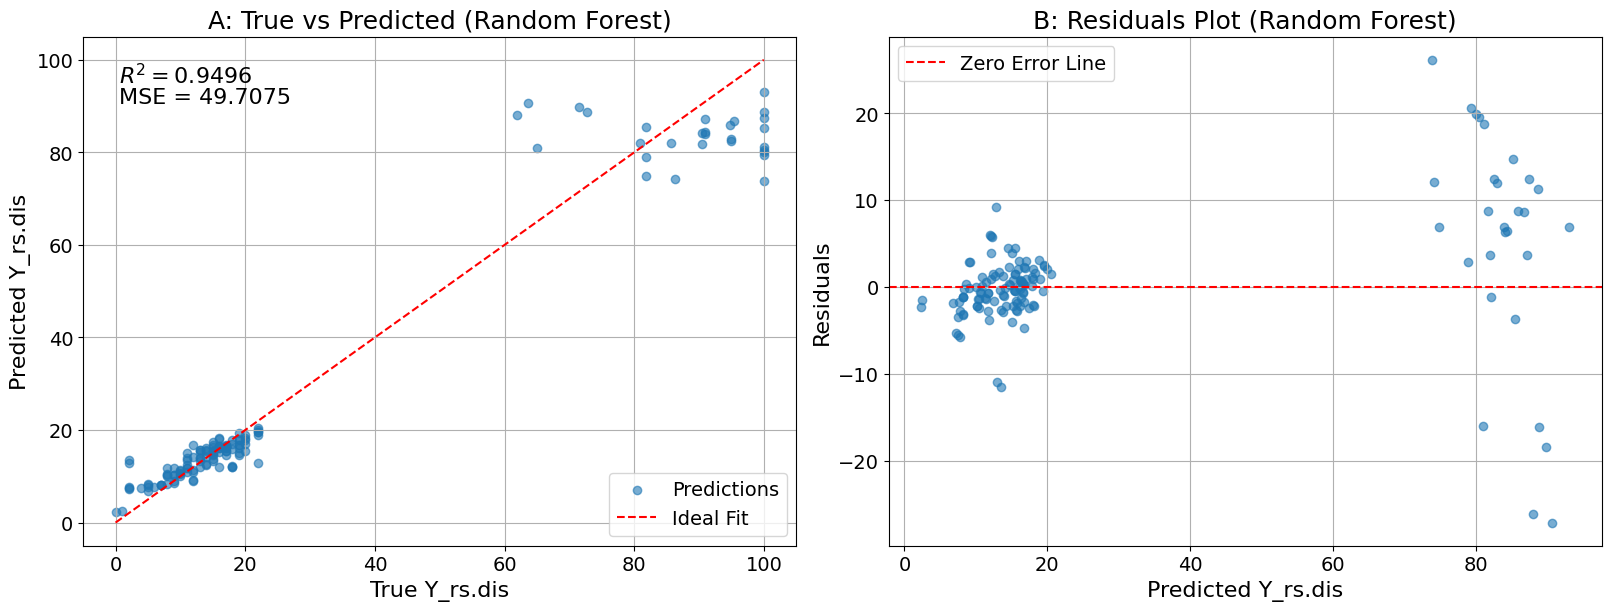

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Font sizes
font_title = 18  # Title font size
font_labels = 16  # Axis label font size
font_ticks = 14  # Tick label font size
font_legend = 14  # Legend font size

# Calculate MSE and R²
mse = mean_squared_error(y_test_reg, y_pred_rf_reg)
r2 = r2_score(y_test_reg, y_pred_rf_reg)

# Generate figure and axes for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot A: True vs Predicted
ideal_x = np.linspace(min(y_test_reg), max(y_test_reg), 100)
ideal_y = ideal_x  # Ideal fit line (y = x)
axes[0].scatter(y_test_reg, y_pred_rf_reg, alpha=0.6, label='Predictions')
axes[0].plot(ideal_x, ideal_y, 'r--', label='Ideal Fit')
axes[0].set_xlabel('True Y_rs.dis', fontsize=font_labels)
axes[0].set_ylabel('Predicted Y_rs.dis', fontsize=font_labels)
axes[0].set_title('A: True vs Predicted (Random Forest)', fontsize=font_title)
axes[0].legend(fontsize=font_legend)
axes[0].grid(True)
axes[0].tick_params(axis='x', labelsize=font_ticks)
axes[0].tick_params(axis='y', labelsize=font_ticks)

# Add MSE and R² annotations
axes[0].text(0.05, 0.95, f"$R^2 = {r2:.4f}$", fontsize=font_labels, transform=axes[0].transAxes, verticalalignment='top')
axes[0].text(0.05, 0.90, f"MSE = {mse:.4f}", fontsize=font_labels, transform=axes[0].transAxes, verticalalignment='top')

# Plot B: Residuals
residuals_rf = y_test_reg - y_pred_rf_reg
axes[1].scatter(y_pred_rf_reg, residuals_rf, alpha=0.6)
axes[1].axhline(0, color='r', linestyle='--', label='Zero Error Line')
axes[1].set_xlabel('Predicted Y_rs.dis', fontsize=font_labels)
axes[1].set_ylabel('Residuals', fontsize=font_labels)
axes[1].set_title('B: Residuals Plot (Random Forest)', fontsize=font_title)
axes[1].legend(fontsize=font_legend)
axes[1].grid(True)
axes[1].tick_params(axis='x', labelsize=font_ticks)
axes[1].tick_params(axis='y', labelsize=font_ticks)

# Show the combined side-by-side plots
plt.show()

In [113]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

# Define predictors and target
X = merged_data[predictors]
y = merged_data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train the SVM model
svm_clf = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)  # Radial Basis Function kernel
svm_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_clf.predict(X_test)
y_prob_svm = svm_clf.predict_proba(X_test)[:, 1]

# Metrics for SVM Classification
svm_acc = accuracy_score(y_test, y_pred_svm)
svm_roc_auc = roc_auc_score(y_test, y_prob_svm)
svm_cm = confusion_matrix(y_test, y_pred_svm)

print("\nSVM Classification (Hold-Out Validation):")
print(f"Accuracy: {svm_acc:.4f}")
print(f"ROC-AUC: {svm_roc_auc:.4f}")
print("Confusion Matrix:")
print(svm_cm)

# Cross-validation for SVM Classification
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store cross-validation results
svm_cv_acc = []
svm_cv_roc_auc = []

for train_idx, test_idx in cv.split(X, y):
    # Split the data for this fold
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx] if isinstance(X, pd.DataFrame) else (X[train_idx], X[test_idx])
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train the SVM model
    svm_cv_model = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)
    svm_cv_model.fit(X_train_cv, y_train_cv)
    
    # Predict on the test set for this fold
    y_pred_cv = svm_cv_model.predict(X_test_cv)
    y_prob_cv = svm_cv_model.predict_proba(X_test_cv)[:, 1]
    
    # Calculate metrics
    acc = accuracy_score(y_test_cv, y_pred_cv)
    roc_auc = roc_auc_score(y_test_cv, y_prob_cv)
    
    # Append metrics to lists
    svm_cv_acc.append(acc)
    svm_cv_roc_auc.append(roc_auc)

# Output cross-validation results
print("\nSVM Cross-Validation Results:")
print(f"Mean Accuracy: {np.mean(svm_cv_acc):.4f}, Std: {np.std(svm_cv_acc):.4f}")
print(f"Mean ROC-AUC: {np.mean(svm_cv_roc_auc):.4f}, Std: {np.std(svm_cv_roc_auc):.4f}")


SVM Classification (Hold-Out Validation):
Accuracy: 0.8921
ROC-AUC: 0.8790
Confusion Matrix:
[[108   0]
 [ 15  16]]

SVM Cross-Validation Results:
Mean Accuracy: 0.9133, Std: 0.0243
Mean ROC-AUC: 0.9186, Std: 0.0571


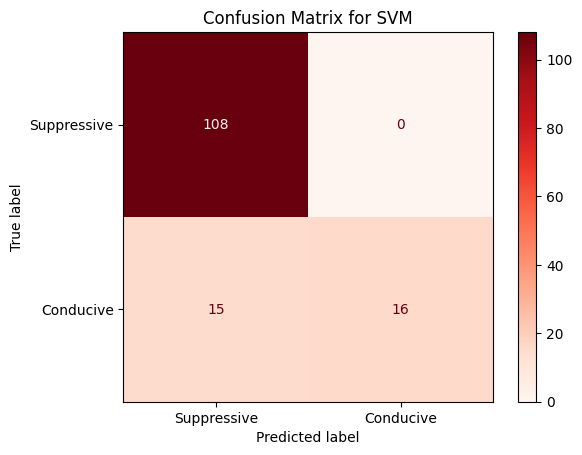

In [114]:
# Plot confusion matrix for SVM
disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=['Suppressive', 'Conducive'])
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix for SVM')
plt.show()

In [115]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Regression Target
y_reg = merged_data['Y_rs.dis']

# Split data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=42
)

# Train the SVR model
svr_reg = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # Radial Basis Function kernel
svr_reg.fit(X_train_reg, y_train_reg)

# Predict on the test set
y_pred_svr = svr_reg.predict(X_test_reg)
residuals_svr = y_test_reg - y_pred_svr

# Metrics for SVR Regression
svr_mse = mean_squared_error(y_test_reg, y_pred_svr)
svr_r2 = r2_score(y_test_reg, y_pred_svr)

print("\nSVM Regression (Hold-Out Validation):")
print(f"Mean Squared Error (MSE): {svr_mse:.4f}")
print(f"R-squared (R²): {svr_r2:.4f}")

# Cross-validation for SVR Regression
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store cross-validation results
svr_cv_mse = []
svr_cv_r2 = []

for train_idx, test_idx in kf.split(X):
    # Split the data for this fold
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx] if isinstance(X, pd.DataFrame) else (X[train_idx], X[test_idx])
    y_train_cv, y_test_cv = y_reg.iloc[train_idx], y_reg.iloc[test_idx]
    
    # Train the SVR model
    svr_cv_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_cv_model.fit(X_train_cv, y_train_cv)
    
    # Predict on the test set for this fold
    y_pred_cv = svr_cv_model.predict(X_test_cv)
    
    # Calculate metrics
    mse = mean_squared_error(y_test_cv, y_pred_cv)
    r2 = r2_score(y_test_cv, y_pred_cv)
    
    # Append metrics to lists
    svr_cv_mse.append(mse)
    svr_cv_r2.append(r2)

# Output cross-validation results
print("\nSVM Regression Cross-Validation Results:")
print(f"Mean MSE: {np.mean(svr_cv_mse):.4f}, Std: {np.std(svr_cv_mse):.4f}")
print(f"Mean R²: {np.mean(svr_cv_r2):.4f}, Std: {np.std(svr_cv_r2):.4f}")


SVM Regression (Hold-Out Validation):
Mean Squared Error (MSE): 1134.1330
R-squared (R²): -0.1502

SVM Regression Cross-Validation Results:
Mean MSE: 856.8181, Std: 176.7167
Mean R²: -0.0876, Std: 0.0352


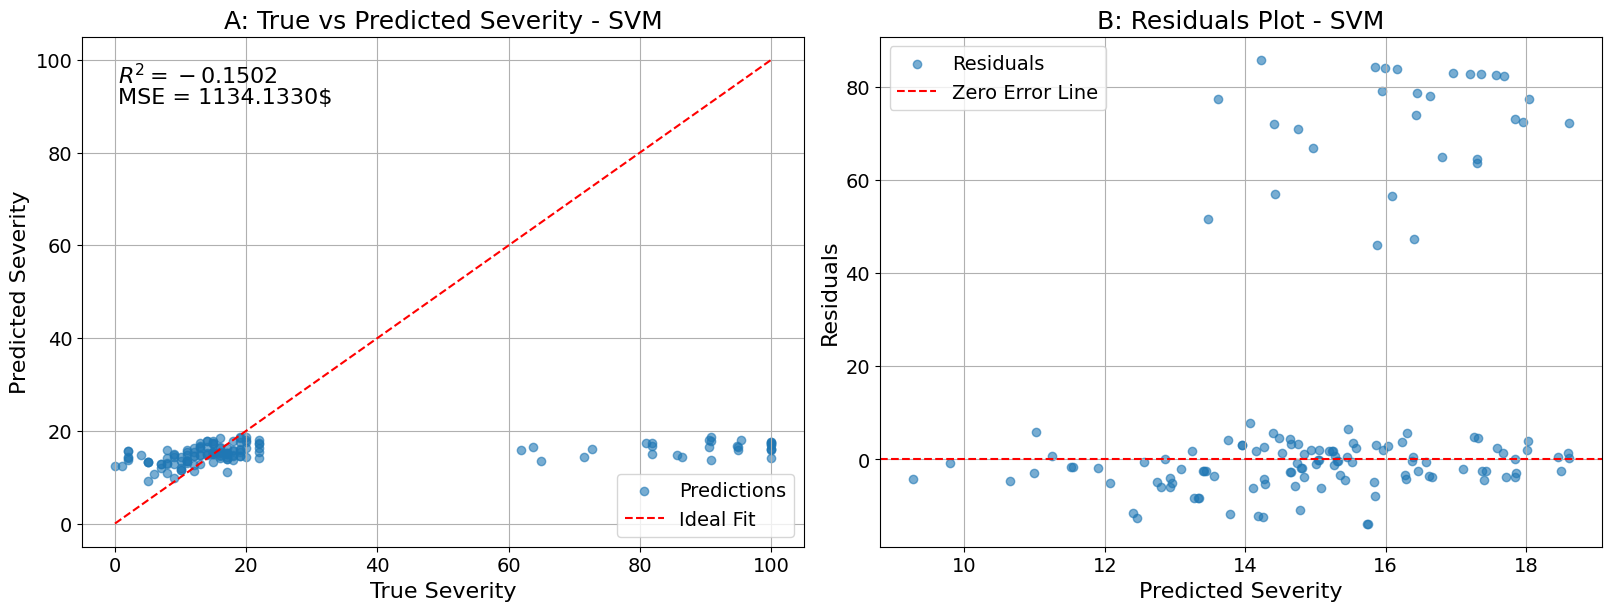

In [116]:
# Font sizes
font_title = 18  # Title font size
font_labels = 16  # Axis label font size
font_ticks = 14  # Tick label font size
font_legend = 14  # Legend font size

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot A: True vs Predicted for SVR Regression
axes[0].scatter(y_test_reg, y_pred_svr, alpha=0.6, label='Predictions')
axes[0].plot(
    [min(y_test_reg), max(y_test_reg)],
    [min(y_test_reg), max(y_test_reg)],
    'r--',
    label='Ideal Fit'
)
axes[0].set_xlabel('True Severity', fontsize=font_labels)
axes[0].set_ylabel('Predicted Severity', fontsize=font_labels)
axes[0].set_title('A: True vs Predicted Severity - SVM', fontsize=font_title)
axes[0].legend(fontsize=font_legend)
axes[0].grid(True)
axes[0].tick_params(axis='x', labelsize=font_ticks)
axes[0].tick_params(axis='y', labelsize=font_ticks)

# Add MSE and R² annotations
axes[0].text(
    0.05, 0.95,
    f"$R^2 = {svr_r2:.4f}$",
    fontsize=font_labels,
    transform=axes[0].transAxes,
    verticalalignment='top'
)
axes[0].text(
    0.05, 0.90,
    f"MSE = {svr_mse:.4f}$",
    fontsize=font_labels,
    transform=axes[0].transAxes,
    verticalalignment='top'
)

# Plot B: Residuals for SVR Regression
axes[1].scatter(y_pred_svr, residuals_svr, alpha=0.6, label='Residuals')
axes[1].axhline(0, color='r', linestyle='--', label='Zero Error Line')
axes[1].set_xlabel('Predicted Severity', fontsize=font_labels)
axes[1].set_ylabel('Residuals', fontsize=font_labels)
axes[1].set_title('B: Residuals Plot - SVM', fontsize=font_title)
axes[1].legend(fontsize=font_legend)
axes[1].grid(True)
axes[1].tick_params(axis='x', labelsize=font_ticks)
axes[1].tick_params(axis='y', labelsize=font_ticks)

# Show the combined plot
plt.show()

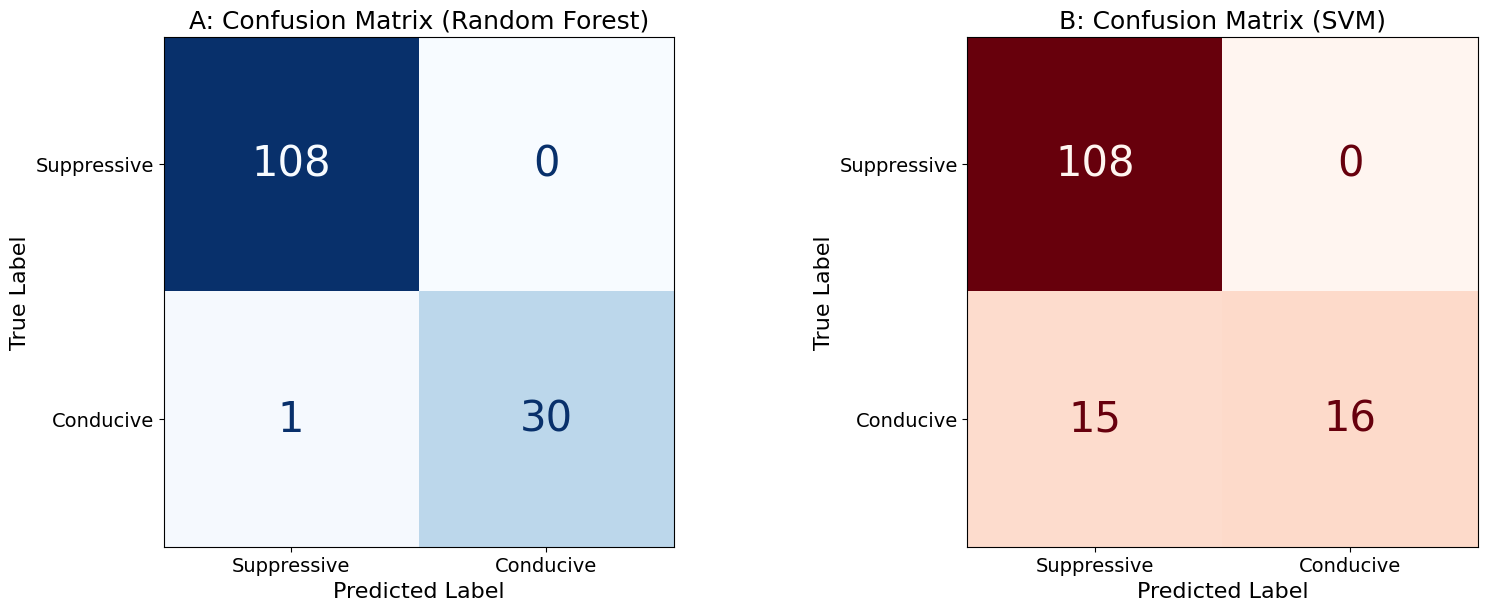

In [117]:
# Font sizes
font_title = 18  # Title font size
font_labels = 16  # Axis label font size
font_ticks = 14  # Tick label font size
font_numbers = 30  # Font size for numbers inside the matrix

# Create side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot A: Confusion Matrix for Random Forest
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=['Suppressive', 'Conducive'])
disp_rf.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
axes[0].set_title('A: Confusion Matrix (Random Forest)', fontsize=font_title)
axes[0].set_xlabel('Predicted Label', fontsize=font_labels)
axes[0].set_ylabel('True Label', fontsize=font_labels)
axes[0].tick_params(axis='x', labelsize=font_ticks)
axes[0].tick_params(axis='y', labelsize=font_ticks)

# Customize text inside the matrix
for text in disp_rf.text_.ravel():
    text.set_fontsize(font_numbers)

# Plot B: Confusion Matrix for SVM
disp_svm = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=['Suppressive', 'Conducive'])
disp_svm.plot(cmap=plt.cm.Reds, ax=axes[1], colorbar=False)
axes[1].set_title('B: Confusion Matrix (SVM)', fontsize=font_title)
axes[1].set_xlabel('Predicted Label', fontsize=font_labels)
axes[1].set_ylabel('True Label', fontsize=font_labels)
axes[1].tick_params(axis='x', labelsize=font_ticks)
axes[1].tick_params(axis='y', labelsize=font_ticks)

for text in disp_svm.text_.ravel():
    text.set_fontsize(font_numbers)

plt.show()

In [118]:
# Save the DataFrame as a CSV file
output_path = '/Users/vbuttros/Library/CloudStorage/OneDrive-Personal/University/Microbiology - DSc/Colaborations/Buttros, VH/R_solanii_ANN/Treated_data/full_data.csv'
merged_data.to_csv(output_path, index=False)

print(f"DataFrame saved to {output_path}")

DataFrame saved to /Users/vbuttros/Library/CloudStorage/OneDrive-Personal/University/Microbiology - DSc/Colaborations/Buttros, VH/R_solanii_ANN/Treated_data/full_data.csv


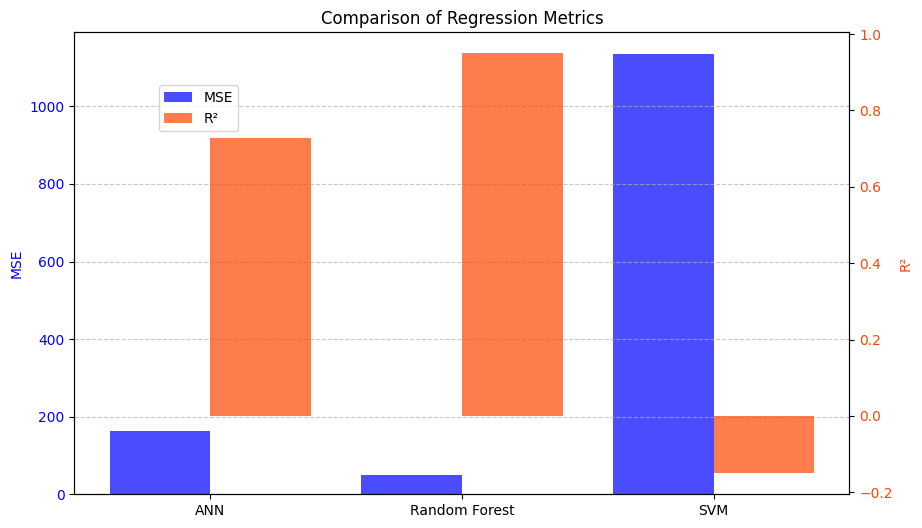

In [119]:
# Metrics computed from the updated script
regression_mse = [ann_mse, rf_mse, svr_mse]
regression_r2 = [ann_r2, rf_r2, svr_r2]
models = ['ANN', 'Random Forest', 'SVM']

# Create a bar plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# x positions for the bars
x = np.arange(len(models))

# Plot MSE on the left y-axis
ax1.bar(x - 0.2, regression_mse, width=0.4, color='blue', alpha=0.7, label='MSE')
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# Add a second y-axis for R²
ax2 = ax1.twinx()
ax2.bar(x + 0.2, regression_r2, width=0.4, color='orangered', alpha=0.7, label='R²')
ax2.set_ylabel('R²', color='orangered')
ax2.tick_params(axis='y', labelcolor='orangered')

# Add title and grid
plt.title('Comparison of Regression Metrics')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

# Show the plot
plt.show()

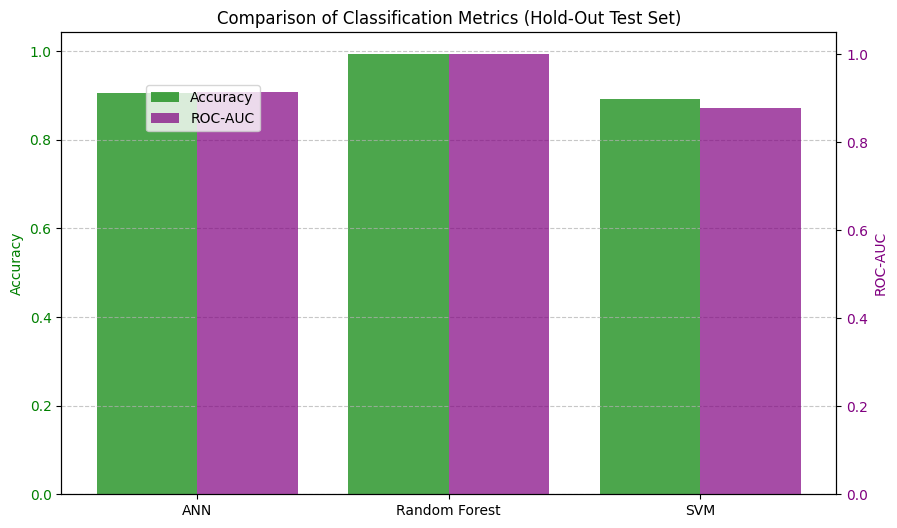

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Define the metrics
classification_accuracy = [accuracy_ann, rf_acc, svm_acc]  # Replace with actual computed values
classification_roc_auc = [roc_auc_ann, rf_roc_auc, svm_roc_auc]  # Replace with actual computed values
models = ['ANN', 'Random Forest', 'SVM']

# Create a bar plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# x positions for the bars
x = np.arange(len(models))

# Plot Accuracy on the left y-axis
ax1.bar(x - 0.2, classification_accuracy, width=0.4, color='green', alpha=0.7, label='Accuracy')
ax1.set_ylabel('Accuracy', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# Add a second y-axis for ROC-AUC
ax2 = ax1.twinx()
ax2.bar(x + 0.2, classification_roc_auc, width=0.4, color='purple', alpha=0.7, label='ROC-AUC')
ax2.set_ylabel('ROC-AUC', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Add title and grid
plt.title('Comparison of Classification Metrics (Hold-Out Test Set)')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

# Show the plot
plt.show()

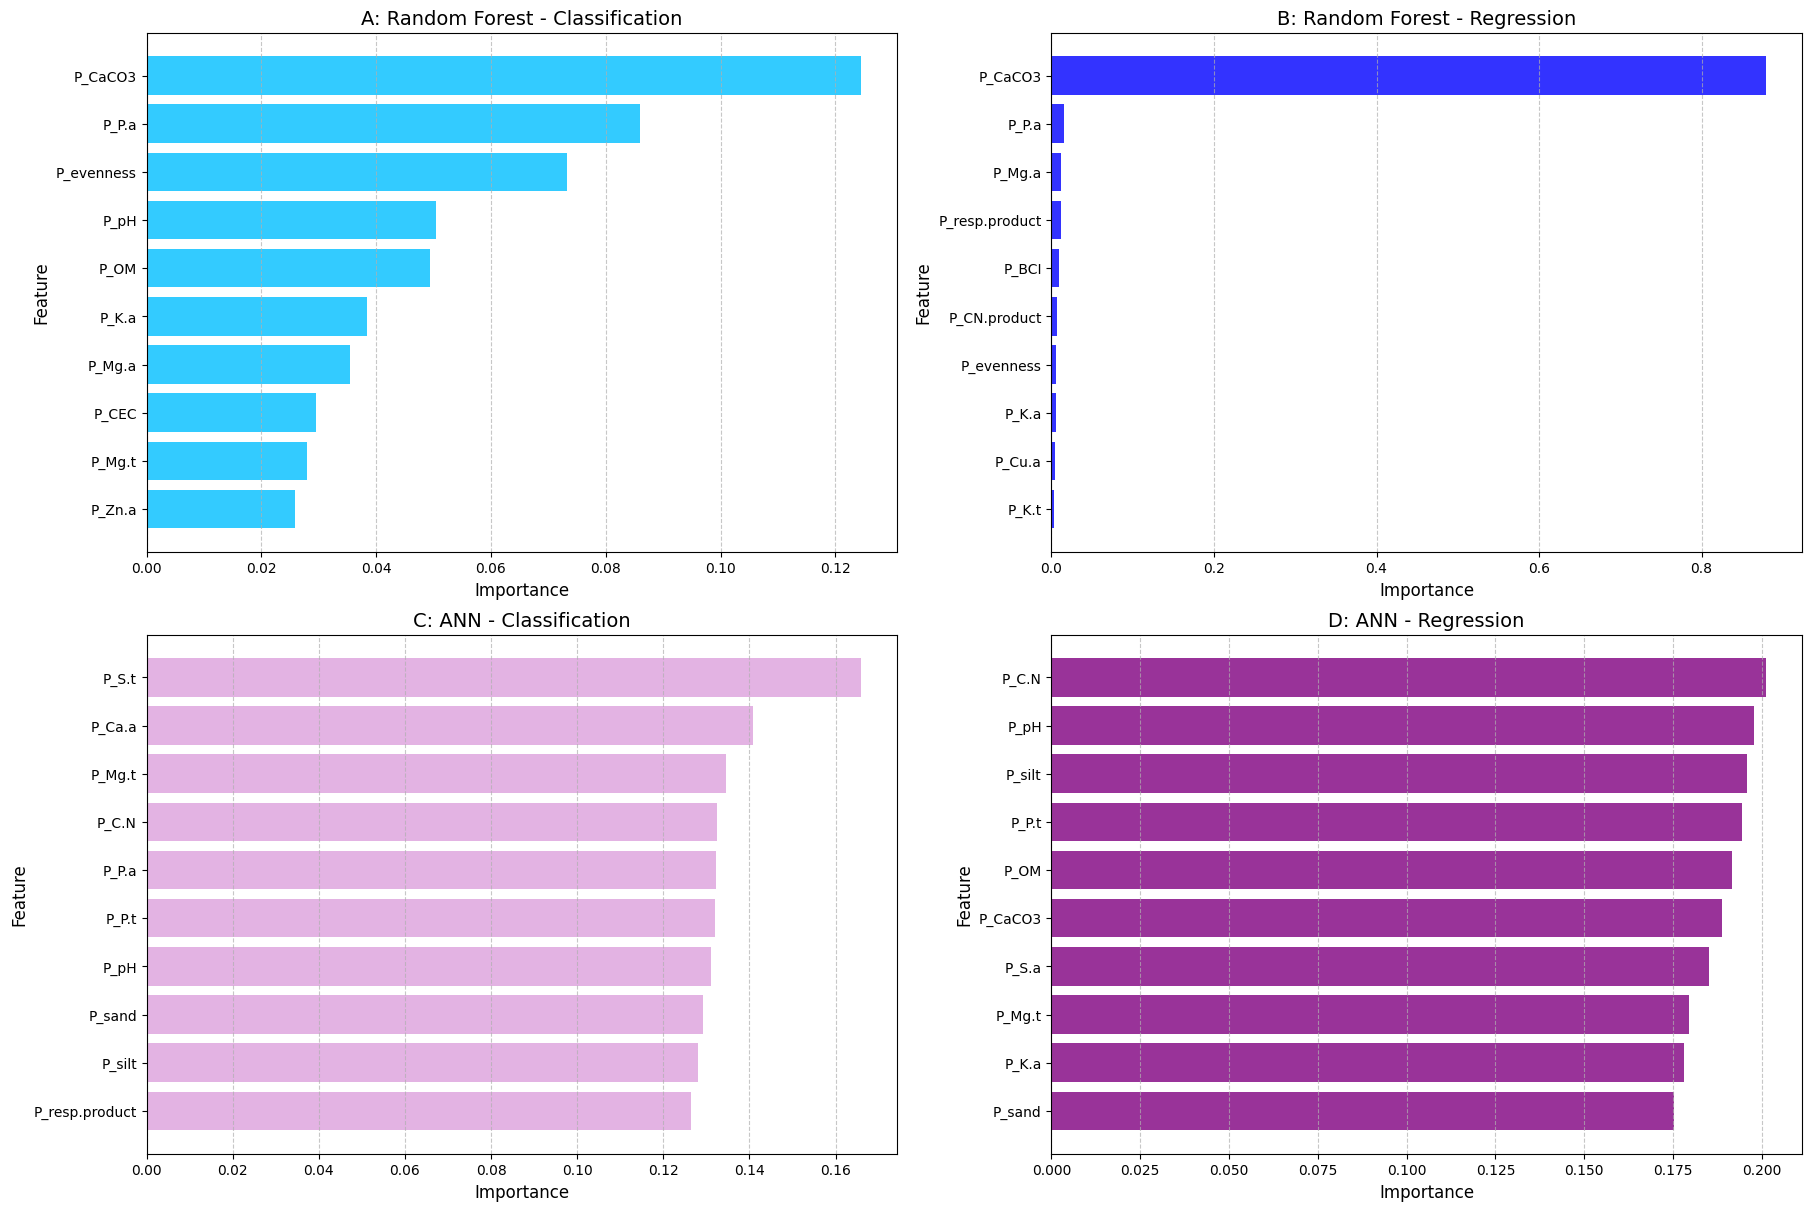

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Retrieve the original feature names
feature_names = merged_data[predictors].columns

# Random Forest Feature Importances (Classification and Regression)
feature_importances_rf_clf = rf_clf.feature_importances_
feature_importances_rf_reg = rf_reg.feature_importances_

# ANN Feature Importances (Classification and Regression)
first_layer_weights_clf = np.abs(ann.coefs_[0])
first_layer_weights_reg = np.abs(ann_reg.coefs_[0])
feature_importances_ann_clf = np.mean(first_layer_weights_clf, axis=1)
feature_importances_ann_reg = np.mean(first_layer_weights_reg, axis=1)

# Create DataFrames for the top 10 features
importance_df_rf_clf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_rf_clf
}).sort_values(by='Importance', ascending=False)

importance_df_rf_reg = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_rf_reg
}).sort_values(by='Importance', ascending=False)

importance_df_ann_clf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_ann_clf
}).sort_values(by='Importance', ascending=False)

importance_df_ann_reg = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_ann_reg
}).sort_values(by='Importance', ascending=False)

# Get top 10 features for each
top_10_rf_clf = importance_df_rf_clf.head(10)
top_10_rf_reg = importance_df_rf_reg.head(10)
top_10_ann_clf = importance_df_ann_clf.head(10)
top_10_ann_reg = importance_df_ann_reg.head(10)

# Create 2x2 plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12), constrained_layout=True)

# Plot A: Random Forest Classification
axes[0, 0].barh(top_10_rf_clf['Feature'], top_10_rf_clf['Importance'], color='deepskyblue', alpha=0.8)
axes[0, 0].set_xlabel('Importance', fontsize=12)
axes[0, 0].set_ylabel('Feature', fontsize=12)
axes[0, 0].set_title('A: Random Forest - Classification', fontsize=14)
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', linestyle='--', alpha=0.7)

# Plot B: Random Forest Regression
axes[0, 1].barh(top_10_rf_reg['Feature'], top_10_rf_reg['Importance'], color='blue', alpha=0.8)
axes[0, 1].set_xlabel('Importance', fontsize=12)
axes[0, 1].set_ylabel('Feature', fontsize=12)
axes[0, 1].set_title('B: Random Forest - Regression', fontsize=14)
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', linestyle='--', alpha=0.7)

# Plot C: ANN Classification
axes[1, 0].barh(top_10_ann_clf['Feature'], top_10_ann_clf['Importance'], color='plum', alpha=0.8)
axes[1, 0].set_xlabel('Importance', fontsize=12)
axes[1, 0].set_ylabel('Feature', fontsize=12)
axes[1, 0].set_title('C: ANN - Classification', fontsize=14)
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', linestyle='--', alpha=0.7)

# Plot D: ANN Regression
axes[1, 1].barh(top_10_ann_reg['Feature'], top_10_ann_reg['Importance'], color='purple', alpha=0.8)
axes[1, 1].set_xlabel('Importance', fontsize=12)
axes[1, 1].set_ylabel('Feature', fontsize=12)
axes[1, 1].set_title('D: ANN - Regression', fontsize=14)
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', linestyle='--', alpha=0.7)

# Show the combined 2x2 plot
plt.show()

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Retrieve the original feature names
feature_names = merged_data[predictors].columns

# Random Forest Feature Importances (Classification and Regression)
feature_importances_rf_clf = rf_clf.feature_importances_
feature_importances_rf_reg = rf_reg.feature_importances_

# ANN Feature Importances (Classification and Regression)
first_layer_weights_clf = np.abs(ann.coefs_[0])
first_layer_weights_reg = np.abs(ann_reg.coefs_[0])
feature_importances_ann_clf = np.mean(first_layer_weights_clf, axis=1)
feature_importances_ann_reg = np.mean(first_layer_weights_reg, axis=1)

# Create DataFrames for the top 10 features
importance_df_rf_clf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_rf_clf
}).sort_values(by='Importance', ascending=False)

importance_df_rf_reg = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_rf_reg
}).sort_values(by='Importance', ascending=False)

importance_df_ann_clf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_ann_clf
}).sort_values(by='Importance', ascending=False)

importance_df_ann_reg = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_ann_reg
}).sort_values(by='Importance', ascending=False)

# Get top 10 features for each
top_10_rf_clf = importance_df_rf_clf.head(10)
top_10_rf_reg = importance_df_rf_reg.head(10)
top_10_ann_clf = importance_df_ann_clf.head(10)
top_10_ann_reg = importance_df_ann_reg.head(10)

# Create 2x2 plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12), constrained_layout=True)

# Plot A: Random Forest Classification
axes[0, 0].barh(top_10_rf_clf['Feature'], top_10_rf_clf['Importance'], color='deepskyblue', alpha=0.8)
axes[0, 0].set_xlabel('Importance', fontsize=12)
axes[0, 0].set_ylabel('Feature', fontsize=12)
axes[0, 0].set_title('A: Random Forest - Classification', fontsize=14)
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', linestyle='--', alpha=0.7)

# Plot B: Random Forest Regression
axes[0, 1].barh(top_10_rf_reg['Feature'], top_10_rf_reg['Importance'], color='blue', alpha=0.8)
axes[0, 1].set_xlabel('Importance', fontsize=12)
axes[0, 1].set_ylabel('Feature', fontsize=12)
axes[0, 1].set_title('B: Random Forest - Regression', fontsize=14)
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', linestyle='--', alpha=0.7)

# Plot C: ANN Classification
axes[1, 0].barh(top_10_ann_clf['Feature'], top_10_ann_clf['Importance'], color='plum', alpha=0.8)
axes[1, 0].set_xlabel('Importance', fontsize=12)
axes[1, 0].set_ylabel('Feature', fontsize=12)
axes[1, 0].set_title('C: ANN - Classification', fontsize=14)
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', linestyle='--', alpha=0.7)

# Plot D: ANN Regression
axes[1, 1].barh(top_10_ann_reg['Feature'], top_10_ann_reg['Importance'], color='purple', alpha=0.8)
axes[1, 1].set_xlabel('Importance', fontsize=12)
axes[1, 1].set_ylabel('Feature', fontsize=12)
axes[1, 1].set_title('D: ANN - Regression', fontsize=14)
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', linestyle='--', alpha=0.7)

# Save the figure as a layered PDF
output_path = '/Users/vbuttros/Library/CloudStorage/OneDrive-Personal/University/Microbiology - DSc/Colaborations/Buttros, VH/R_solanii_ANN/Chapter/Feature_Importance_2x2.pdf'
with PdfPages(output_path) as pdf:
    pdf.savefig(fig)  # Save the figure in the PDF
    plt.close(fig)  # Close the figure after saving

print(f"Layered PDF saved as {output_path}")

Layered PDF saved as /Users/vbuttros/Library/CloudStorage/OneDrive-Personal/University/Microbiology - DSc/Colaborations/Buttros, VH/R_solanii_ANN/Chapter/Feature_Importance_2x2.pdf


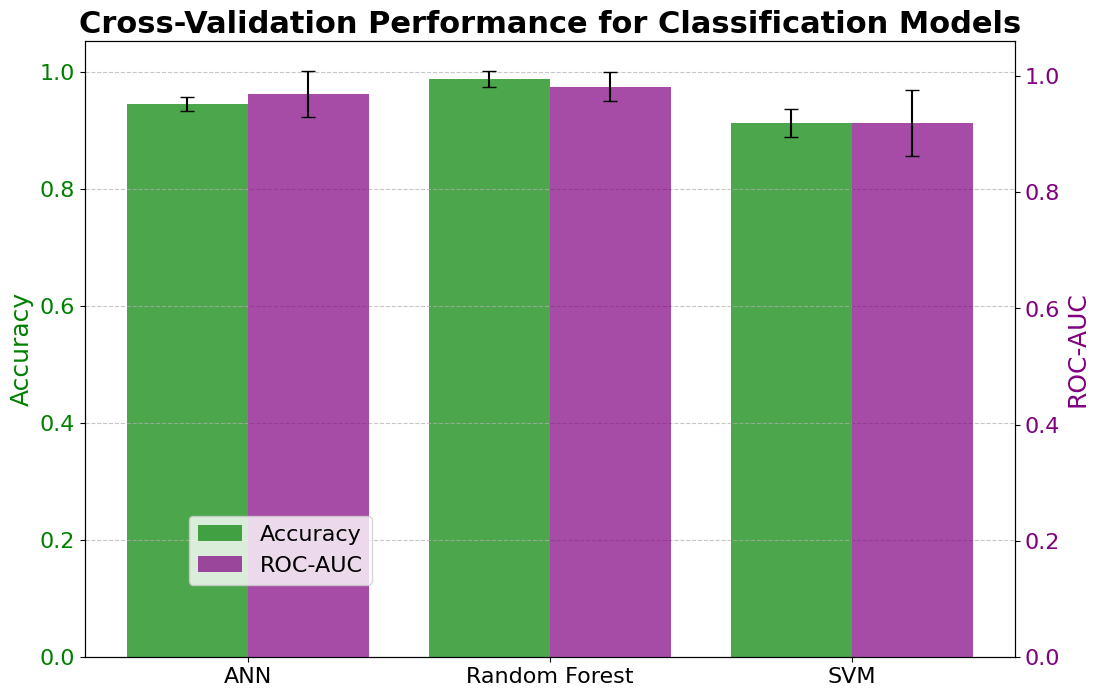

In [123]:
# Cross-Validation Performance for Classification Models
import numpy as np
import matplotlib.pyplot as plt

classification_accuracy_cv = [np.mean(cv_accuracies), np.mean(rf_cv_accuracies), np.mean(svm_cv_acc)]
classification_roc_auc_cv = [np.mean(cv_roc_auc), np.mean(rf_cv_roc_auc), np.mean(svm_cv_roc_auc)]

classification_accuracy_std = [np.std(cv_accuracies), np.std(rf_cv_accuracies), np.std(svm_cv_acc)]
classification_roc_auc_std = [np.std(cv_roc_auc), np.std(rf_cv_roc_auc), np.std(svm_cv_roc_auc)]

models = ['ANN', 'Random Forest', 'SVM']
fig, ax1 = plt.subplots(figsize=(12, 8))  # Increased figure size for better readability

x = np.arange(len(models))
ax1.bar(x - 0.2, classification_accuracy_cv, yerr=classification_accuracy_std, capsize=5,
        width=0.4, color='green', alpha=0.7, label='Accuracy')
ax1.set_ylabel('Accuracy', color='green', fontsize=18)  # Larger font
ax1.tick_params(axis='y', labelcolor='green', labelsize=16)  # Larger tick labels
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=16)
ax2 = ax1.twinx()
ax2.bar(x + 0.2, classification_roc_auc_cv, yerr=classification_roc_auc_std, capsize=5,
        width=0.4, color='purple', alpha=0.7, label='ROC-AUC')
ax2.set_ylabel('ROC-AUC', color='purple', fontsize=18)
ax2.tick_params(axis='y', labelcolor='purple', labelsize=16)
plt.title('Cross-Validation Performance for Classification Models', fontsize=22, fontweight='bold')  # Larger title
ax1.grid(axis='y', linestyle='--', alpha=0.7)
fig.legend(loc='lower left', bbox_to_anchor=(0.1, 0.1), bbox_transform=ax1.transAxes, fontsize=16)
plt.show()

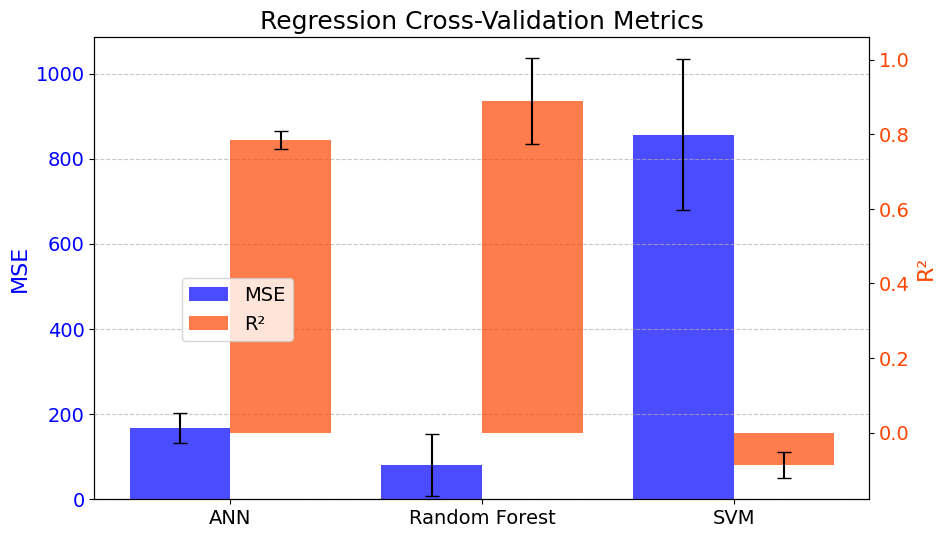

In [124]:
# Regression Cross-Validation Metrics
import numpy as np
import matplotlib.pyplot as plt

models = ['ANN', 'Random Forest', 'SVM']

cv_mse_mean = [np.mean(ann_cv_mse), np.mean(rf_cv_mse_r), np.mean(svr_cv_mse)]
cv_mse_std = [np.std(ann_cv_mse), np.std(rf_cv_mse_r), np.std(svr_cv_mse)]
cv_r2_mean = [np.mean(ann_cv_r2), np.mean(rf_cv_r2_r), np.mean(svr_cv_r2)]
cv_r2_std = [np.std(ann_cv_r2), np.std(rf_cv_r2_r), np.std(svr_cv_r2)]

fig, ax1 = plt.subplots(figsize=(10, 6))

x = np.arange(len(models))

ax1.bar(x - 0.2, cv_mse_mean, yerr=cv_mse_std, width=0.4, color='blue', alpha=0.7, label='MSE', capsize=5)
ax1.set_ylabel('MSE', color='blue', fontsize=16)  # Larger y-axis label
ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)  # Larger y-axis ticks
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=14)
ax2 = ax1.twinx()
ax2.bar(x + 0.2, cv_r2_mean, yerr=cv_r2_std, width=0.4, color='orangered', alpha=0.7, label='R²', capsize=5)
ax2.set_ylabel('R²', color='orangered', fontsize=16)  # Larger y-axis label
ax2.tick_params(axis='y', labelcolor='orangered', labelsize=14)  # Larger y-axis ticks
plt.title('Regression Cross-Validation Metrics', fontsize=18)  # Larger title
ax1.grid(axis='y', linestyle='--', alpha=0.7)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.5), bbox_transform=ax1.transAxes, fontsize=14)
plt.show()